<a href="https://colab.research.google.com/github/alex-addanki/Experiments/blob/master/Hackathon_Spoken_Digit_Identification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython import get_ipython
ipython = get_ipython()
ipython.magic("sx unzip free-spoken-digit-dataset-master.zip")

In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import librosa

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
os.listdir(r"free-spoken-digit-dataset-master")

# Any results you write to the current directory are saved as output.

['metadata.py',
 '__init__.py',
 'README.md',
 'acquire_data',
 'pip_requirements.txt',
 '.gitignore',
 'recordings',
 'utils']

In [7]:
from keras.utils import to_categorical
from tqdm import tqdm

def wav2mfcc(file_path, augment = False, max_pad_len=11):
    wave, sr = librosa.load(file_path, mono=True, sr=8000, duration = 1.024)
    
    if augment == True:
        bins_per_octave = 12
        pitch_pm = 4
        pitch_change =  pitch_pm * 2*(np.random.uniform())   
        wave = librosa.effects.pitch_shift(wave, 
                                          8000, n_steps=pitch_change, 
                                          bins_per_octave=bins_per_octave)
        
        speed_change = np.random.uniform(low=0.9,high=1.1)
        wave = librosa.effects.time_stretch(wave, speed_change)
        wave = wave[:8192]

    duration = wave.shape[0]/sr
    speed_change = 2.0* duration/1.024
    wave = librosa.effects.time_stretch(wave, speed_change)
    wave = wave[:4096]
    
    wave = librosa.util.normalize(wave)
    mfcc = librosa.feature.mfcc(wave, sr=sr, n_mfcc=40, hop_length=int(0.048*sr), n_fft=int(0.096*sr))
    mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
    #print("shape=",mfcc.shape[1], wave.shape[0])
    pad_width = max_pad_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    #mfcc = mfcc[2:24,:]
    return mfcc, duration, sr

def get_data(dir = '', augment= False):
    labels = []
    mfccs = []
    durations = []
    sampling_rates = []
    filenames = []

    for f in tqdm(os.listdir(dir)):
        if f.endswith('.wav'):
            mfcc, duration, sr = wav2mfcc(dir + "/" + f, augment)
            mfccs.append(mfcc)
            durations.append(duration)
            sampling_rates.append(sr)
            # List of labels
            label = f.split('_')[0]
            labels.append(label)
            filenames.append(dir + "/" + f)
    return filenames, np.asarray(mfccs), np.asarray(durations), np.asarray(sampling_rates), to_categorical(labels), labels

Using TensorFlow backend.


In [8]:
#filenames, mfccs, durations, sampling_rates, labels, cls_true = get_data('/content/')
filenames, mfccs, durations, sampling_rates, labels, cls_true = get_data('free-spoken-digit-dataset-master/recordings')

100%|██████████| 1500/1500 [03:33<00:00,  7.16it/s]


In [0]:
import matplotlib.pyplot as plt
import librosa.display

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(15,15))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    max = np.max(images)
    min = np.min(images)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        #ax.imshow(images[i].reshape(img_shape), cmap='binary')
        im = librosa.display.specshow(images[i], ax=ax, vmin=min, vmax=max)

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [0]:
plot_images(mfccs[100:109], cls_true[100:109])

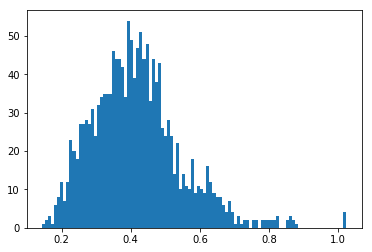

In [11]:
n, bins, patches = plt.hist(durations, bins=100)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

#from ann_visualizer.visualize import ann_viz

def get_cnn_model(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(4, 4), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())

    model.add(Conv2D(48, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(120, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

    return model

In [0]:
from sklearn.model_selection import train_test_split

def get_all():
    filenames, mfccs, durations, sampling_rates, labels, cls_true = get_data('free-spoken-digit-dataset-master/recordings', augment = False)
    
    filenames_a, mfccs_a, durations_a, sampling_rates_a, labels_a, cls_true_a = get_data('free-spoken-digit-dataset-master/recordings', augment = True)

    mfccs = np.append(mfccs, mfccs_a, axis=0)
    labels = np.append(labels, labels_a, axis =0)
    
    dim_1 = mfccs.shape[1]
    dim_2 = mfccs.shape[2]
    channels = 1
    classes = 10
    
    print("sampling rate (max) = ", np.max(sampling_rates))
    print("sampling rate (min) = ", np.min(sampling_rates))
    print("duration (max) = ", np.max(durations))
    print("duration (avg) = ", np.average(durations))
    print("duration (min) = ", np.min(durations))
    print("mffc matrix = ", mfccs.shape)

    X = mfccs
    X = X.reshape((mfccs.shape[0], dim_1, dim_2, channels))
    y = labels

    input_shape = (dim_1, dim_2, channels)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    model = get_cnn_model(input_shape, classes)

    return X_train, X_test, y_train, y_test, model

In [16]:
X_train, X_test, y_train, y_test, cnn_model = get_all()

print(cnn_model.summary())

cnn_model.fit(X_train, y_train, batch_size=64, epochs=15, verbose=1, validation_split=0.1)

100%|██████████| 1500/1500 [03:59<00:00,  5.93it/s]


sampling rate (max) =  8000
sampling rate (min) =  8000
duration (max) =  1.024
duration (avg) =  0.41654141666666666
duration (min) =  0.143625
mffc matrix =  (3000, 40, 11)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 37, 8, 32)         544       
_________________________________________________________________
batch_normalization_1 (Batch (None, 37, 8, 32)         128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 35, 6, 48)         13872     
_________________________________________________________________
batch_normalization_2 (Batch (None, 35, 6, 48)         192       
____________________________________________

In [17]:
from sklearn.metrics import classification_report
predictions = cnn_model.predict_classes(X_test)
print(classification_report(y_test, to_categorical(predictions)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        54
           1       0.98      0.91      0.94        53
           2       0.90      0.95      0.92        63
           3       0.95      0.89      0.92        71
           4       0.93      0.96      0.94        53
           5       0.94      0.98      0.96        60
           6       0.92      0.97      0.95        63
           7       0.92      0.92      0.92        75
           8       0.95      0.89      0.92        44
           9       0.98      0.95      0.97        64

   micro avg       0.94      0.94      0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600
 samples avg       0.94      0.94      0.94       600



In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(np.argmax(y_test, axis=1), predictions, labels=[0,1,2,3,4,5,6,7,8,9])

array([[54,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 48,  0,  0,  2,  0,  1,  1,  0,  1],
       [ 0,  0, 60,  2,  0,  0,  1,  0,  0,  0],
       [ 1,  0,  6, 63,  0,  0,  0,  1,  0,  0],
       [ 1,  0,  0,  0, 51,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0, 59,  0,  1,  0,  0],
       [ 0,  0,  1,  0,  0,  0, 61,  1,  0,  0],
       [ 0,  0,  0,  0,  2,  1,  1, 69,  2,  0],
       [ 0,  0,  0,  1,  0,  2,  2,  0, 39,  0],
       [ 0,  1,  0,  0,  0,  1,  0,  1,  0, 61]])

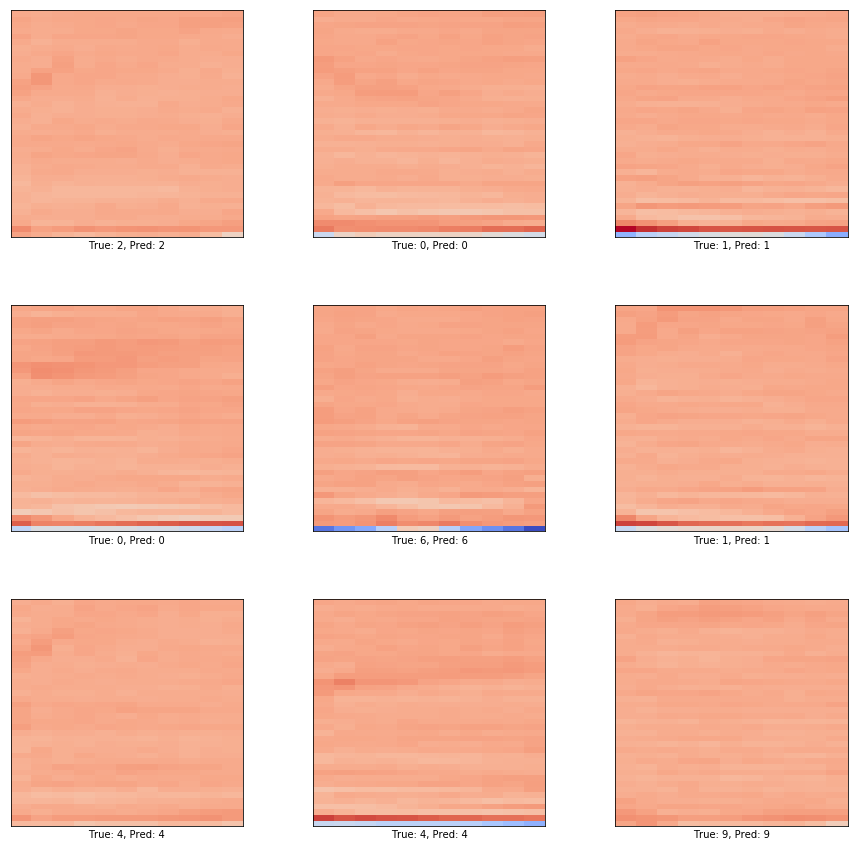

In [19]:
n = X_test[100:109]
n = n.reshape(n.shape[0], n.shape[1], n.shape[2])
plot_images(n, np.argmax(y_test[100:109], axis=1), predictions[100:109])

In [0]:
import pickle
filename = 'Hackathon_Spoken_Digit_Identification_model.sav'
pickle.dump(cnn_model, open(filename, 'wb'))

In [0]:
ipython.magic("sx unzip input.zip")

**MODEL TRAINED NOW --- Validation Using Pickle file**

In [0]:
def get_mydata():
    #filenames, mfccs, durations, sampling_rates, labels, cls_true = get_data(r"input/spoken")
    filenames, mfccs, durations, sampling_rates, labels, cls_true = get_data(r"recordings")
    dim_1 = mfccs.shape[1]
    dim_2 = mfccs.shape[2]
    channels = 1
    classes = 10
    
    print("sampling rate (max) = ", np.max(sampling_rates))
    print("sampling rate (min) = ", np.min(sampling_rates))
    print("duration (max) = ", np.max(durations))
    print("duration (avg) = ", np.average(durations))
    print("duration (min) = ", np.min(durations))
    print("mffc matrix = ", mfccs.shape)

    X = mfccs
    X = X.reshape((mfccs.shape[0], dim_1, dim_2, channels))
    y = labels

    return X, y

In [57]:
X,y = get_mydata()

100%|██████████| 30/30 [00:06<00:00,  5.22it/s]

sampling rate (max) =  8000
sampling rate (min) =  8000
duration (max) =  1.024
duration (avg) =  0.5802
duration (min) =  0.000625
mffc matrix =  (30, 40, 11)


In [0]:
#predictions = cnn_model.predict(X)
filename = 'Hackathon_Spoken_Digit_Identification_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(X)
print(result)

In [59]:
np.argmax(result,axis=1)

array([4, 5, 9, 4, 9, 4, 1, 5, 5, 4, 8, 1, 5, 4, 3, 5, 6, 2, 6, 4, 7, 3,
       5, 4, 3, 1, 4, 4, 5, 4])

In [60]:
np.argmax(y,axis=1)

array([2, 0, 9, 4, 9, 5, 6, 7, 6, 1, 3, 1, 8, 7, 0, 0, 5, 4, 3, 9, 8, 6,
       5, 2, 8, 1, 7, 4, 2, 3])

In [0]:
import pandas as pd

pred = pd.DataFrame(index=np.argmax(y,axis=1), data=result*100)

In [62]:
pred

,0,1,2,3,4,5,6,7,8,9
2,0.864625,0.008682,0.037727,6.579122,92.387932,0.004047,0.039741,0.055877,0.012404,0.009844
0,0.072458,1.507297,0.221927,0.292446,0.175154,53.618748,37.370140,3.422168,1.805514,1.514151
9,0.914462,42.237808,0.122248,0.315804,0.148939,6.131190,0.049234,0.209035,0.066569,49.804714
4,2.358025,22.050240,0.771416,1.089141,61.275101,4.819954,2.224035,0.472433,1.013259,3.926394
9,2.043492,39.243069,0.300996,5.825866,2.464174,7.928587,0.331963,0.585977,0.196765,41.079109
5,2.222385,1.957831,6.509412,24.356112,41.490223,13.154337,1.132963,5.294145,0.100400,3.782185
6,0.456094,38.642948,0.312560,0.551417,27.989214,21.085962,3.697352,2.838753,0.467027,3.958674
7,0.120247,9.308505,0.476980,1.313896,14.412997,43.131767,19.167511,4.435815,4.416334,3.215941
6,0.012323,0.581716,0.156959,0.126454,0.551491,92.624557,4.525544,1.006074,0.173226,0.241664
1,0.660238,27.247698,9.747497,6.317802,54.216705,0.158168,0.064008,0.943180,0.078654,0.566059


In [63]:
#filenames, mfccs, durations, sampling_rates, labels, cls_true = get_data(r"input/spoken")
filenames, mfccs, durations, sampling_rates, labels, cls_true = get_data(r"recordings")

100%|██████████| 30/30 [00:06<00:00,  5.24it/s]


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memo

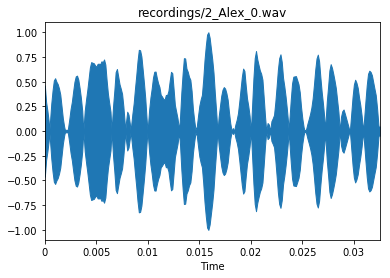

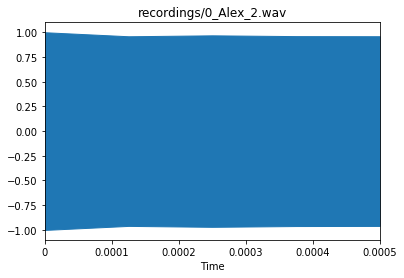

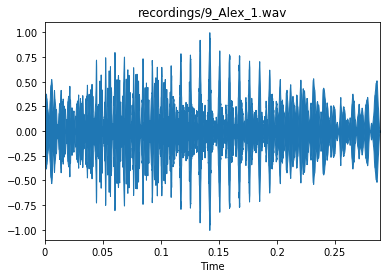

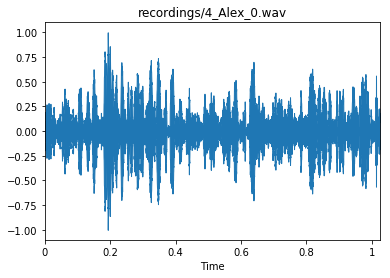

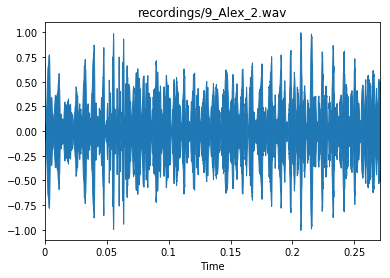

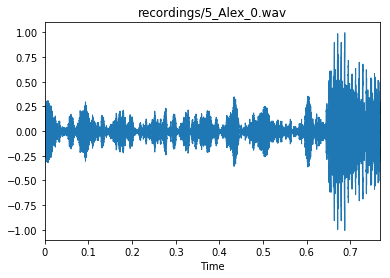

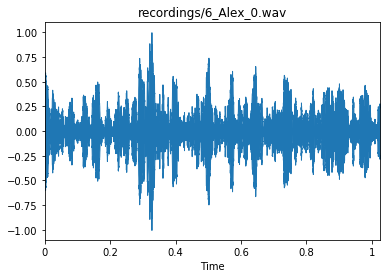

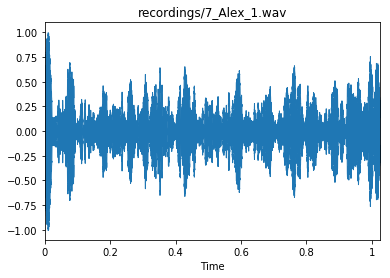

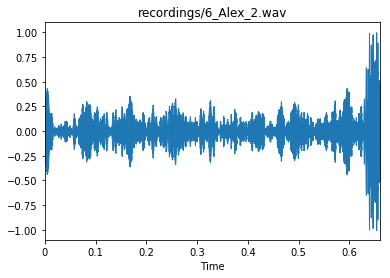

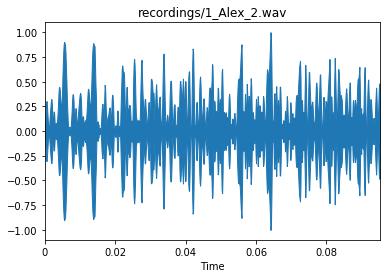

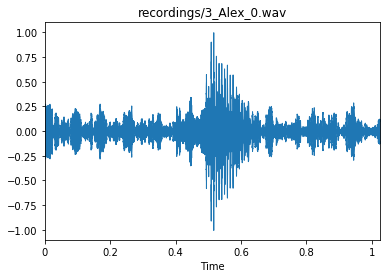

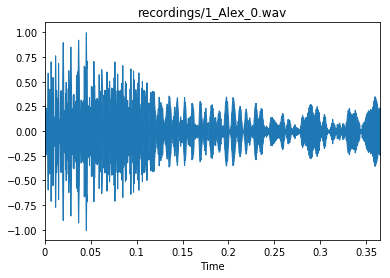

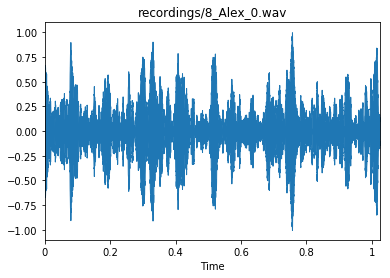

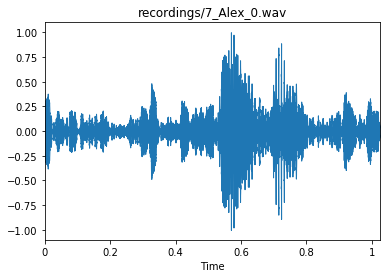

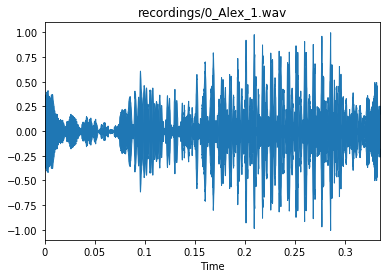

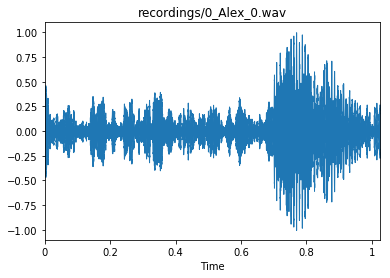

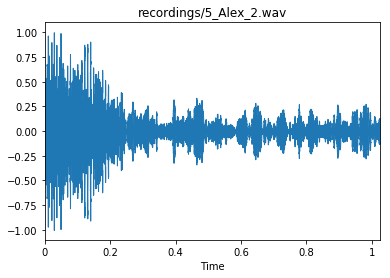

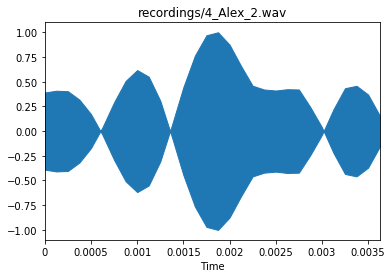

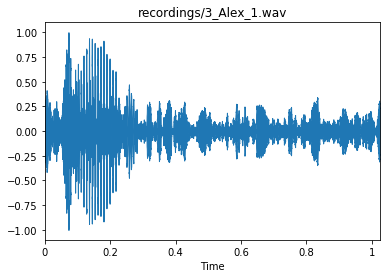

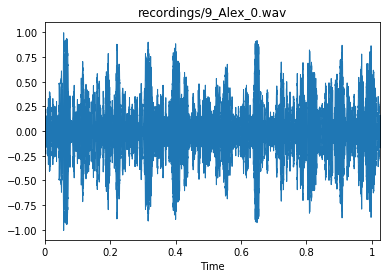

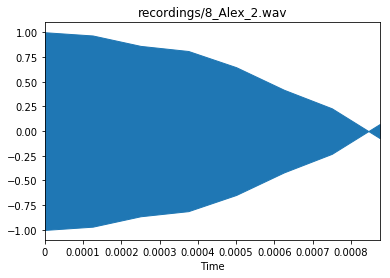

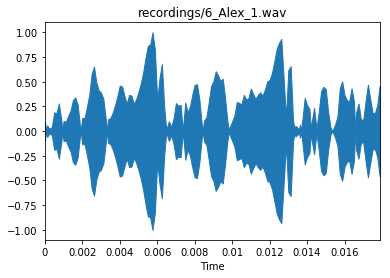

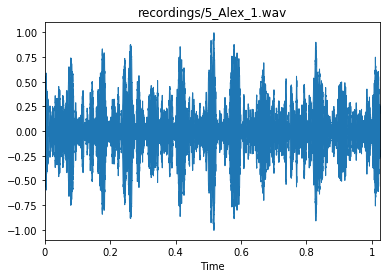

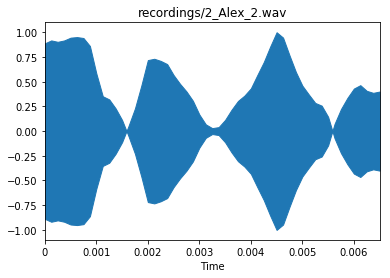

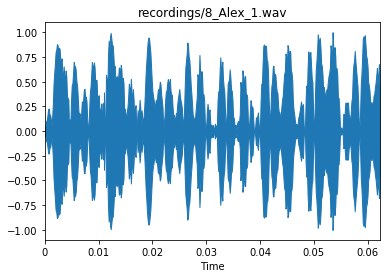

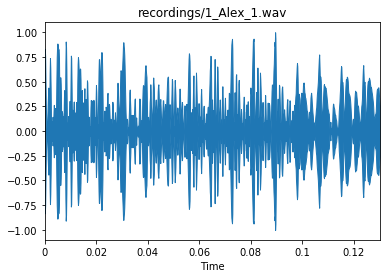

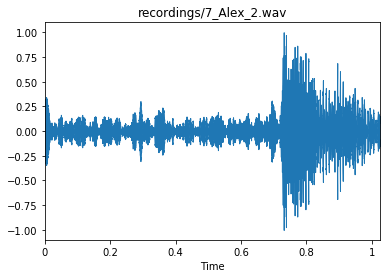

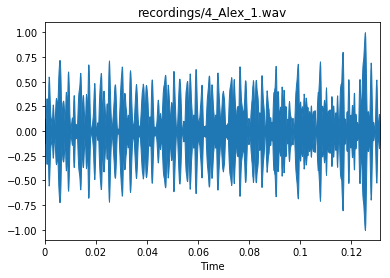

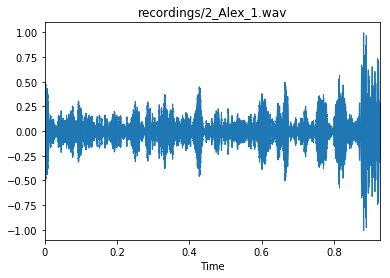

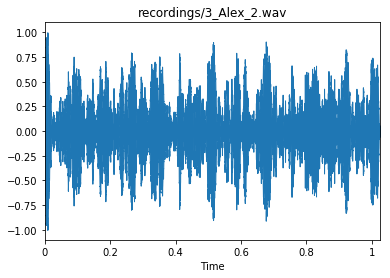

In [64]:
for file in filenames:
    wave, sr = librosa.load(file, mono=True, sr=8000, duration = 1.024)
    plt.figure()
    plt.title(file)
    librosa.display.waveplot(librosa.util.normalize(wave),sr=sr)

In [65]:
filenames

['recordings/2_Alex_0.wav',
 'recordings/0_Alex_2.wav',
 'recordings/9_Alex_1.wav',
 'recordings/4_Alex_0.wav',
 'recordings/9_Alex_2.wav',
 'recordings/5_Alex_0.wav',
 'recordings/6_Alex_0.wav',
 'recordings/7_Alex_1.wav',
 'recordings/6_Alex_2.wav',
 'recordings/1_Alex_2.wav',
 'recordings/3_Alex_0.wav',
 'recordings/1_Alex_0.wav',
 'recordings/8_Alex_0.wav',
 'recordings/7_Alex_0.wav',
 'recordings/0_Alex_1.wav',
 'recordings/0_Alex_0.wav',
 'recordings/5_Alex_2.wav',
 'recordings/4_Alex_2.wav',
 'recordings/3_Alex_1.wav',
 'recordings/9_Alex_0.wav',
 'recordings/8_Alex_2.wav',
 'recordings/6_Alex_1.wav',
 'recordings/5_Alex_1.wav',
 'recordings/2_Alex_2.wav',
 'recordings/8_Alex_1.wav',
 'recordings/1_Alex_1.wav',
 'recordings/7_Alex_2.wav',
 'recordings/4_Alex_1.wav',
 'recordings/2_Alex_1.wav',
 'recordings/3_Alex_2.wav']

In [68]:
import IPython
IPython.display.Audio(filenames[3])

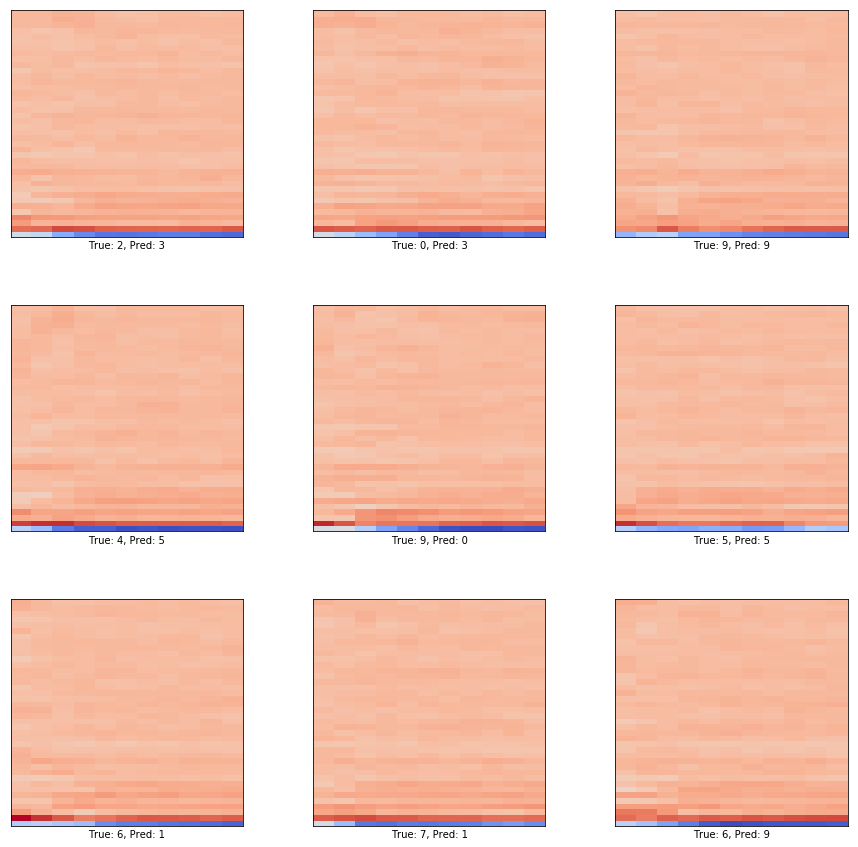

In [54]:
n = X[0:9]
n = n.reshape(n.shape[0], n.shape[1], n.shape[2])
plot_images(n, np.argmax(y[0:9], axis=1), np.argmax(result,axis=1))